In [1]:
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import torch
import random
from torch import nn, optim
from torch.autograd.variable import Variable
import logging as log
from torchvision import transforms, datasets
BATCH_SIZE = 200
DATASET = 3000

In [2]:
np.random.seed(0)
random.seed(0)
torch.manual_seed(0)
torch.cuda.manual_seed(0)
torch.cuda.manual_seed_all(0)
torch.backends.cudnn.enabled = False
torch.backends.cudnn.benchmark = False
torch.backends.cudnn.deterministic = True

In [3]:
class Points:
    def __init__(self,ids):
        self.ids = ids
    def __len__(self):
        return len(self.ids)
    def __getitem__(self,index):
        Id = self.ids[index]
        X = torch.load('data/'+str(Id)+'.pt')
        return X

In [4]:
ids = np.arange(1,DATASET+1,1)
training = Points(ids)

In [5]:
training_loader = torch.utils.data.DataLoader(training, shuffle = False, batch_size=BATCH_SIZE, worker_init_fn=np.random.seed(0),num_workers=0)
num_batches = len(training_loader)

# NETWORKS

In [7]:
class Generator(nn.Module):
    '''
    Two hidden layered generator
    '''
    def __init__(self):
        super(Generator,self).__init__()
        n_features = 2
        n_hidden1 = 10
        n_hidden2 = 10
        n_out = 3
        
        self.hidden1 = nn.Sequential(nn.Linear(n_features,n_hidden1),nn.LeakyReLU(0.2))
        self.hidden2 = nn.Sequential(nn.Linear(n_hidden1,n_hidden2),nn.LeakyReLU(0.2))
        self.out = nn.Sequential(nn.Linear(n_hidden2,n_out),nn.Sigmoid())
        
    def forward(self,x):
        x = self.hidden1(x)
        x = self.hidden2(x)
        x = self.out(x)
        return x    

In [8]:
class Discriminator(torch.nn.Module):
    '''
    Single hidden layer discriminator network
    '''
    def __init__(self):
        super(Discriminator,self).__init__()
        n_features = 5
        n_hidden1 = 10
        n_out = 1
        
        self.hidden = nn.Sequential(nn.Linear(n_features,n_hidden1),nn.LeakyReLU(0.2),nn.Dropout(0.3))
        self.out = nn.Sequential(nn.Linear(n_hidden1,n_out),nn.Sigmoid())
        
    def forward(self,x):
        x = self.hidden(x)
        x = self.out(x)
        return x

In [14]:
disc = Discriminator()
disc.load_state_dict(torch.load('models/disc_initial.pt'))
gen = Generator()
gen.load_state_dict(torch.load('models/gen_initial.pt'))
disc.cuda()
gen.cuda()

Generator(
  (hidden1): Sequential(
    (0): Linear(in_features=2, out_features=10, bias=True)
    (1): LeakyReLU(negative_slope=0.2)
  )
  (hidden2): Sequential(
    (0): Linear(in_features=10, out_features=10, bias=True)
    (1): LeakyReLU(negative_slope=0.2)
  )
  (out): Sequential(
    (0): Linear(in_features=10, out_features=3, bias=True)
    (1): Sigmoid()
  )
)

In [10]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'

In [16]:
# for p in disc.parameters():
#     print(p)
#     print(p.device)

In [12]:
# torch.save(gen.state_dict(),'models/gen_initial.pt')
# torch.save(disc.state_dict(),'models/disc_initial.pt')

In [168]:
# model = Generator()
# model.load_state_dict(torch.load('models/model1/gen_initial.pt'))

# OPTIMIZER

In [17]:
d_opt = optim.Adam(disc.parameters(), lr = 0.0002)
g_opt = optim.Adam(gen.parameters(), lr = 0.0002)

In [49]:
# torch.save(g_opt.state_dict(),'models/model1/genopt_initial.pt')
# torch.save(d_opt.state_dict(),'models/model1/discopt_initial.pt')

# CREATING LABELS

In [18]:
def real_data_target(size):
    o = torch.ones(size,1,dtype = torch.float32,device = device)-.05
    return o
def fake_data_target(size):
    z = torch.zeros(size,1,dtype= torch.float32, device = device)+.05
    return z

# LOSS FUNCTIONS

In [34]:
def loss_l1(a,b):
    return torch.mean(torch.abs(a-b),1)
loss_bce = torch.nn.BCELoss()

In [52]:
haha = torch.tensor([[1.0,2.0],[1.0,2.0]])
hihi = torch.tensor([[2.0,5.0],[2.0,6.0]])
torch.cat((haha,hihi),dim = 1)

tensor([[1., 2., 2., 5.],
        [1., 2., 2., 6.]])

# TRAINING FUNCTIONS

In [52]:
def train_discriminator(optimizer, real_data, fake_data):
    #set optimizer gradients to zero to store fresh gradients
    optimizer.zero_grad()
    
    #adversarial discriminator loss
    prediction_real = disc(real_data) 
    error_real = loss_bce(prediction_real, real_data_target(real_data.size(0)))

    #adversarial generative loss
    prediction_fake = disc(fake_data)    
    error_fake = loss_bce(prediction_fake, fake_data_target(fake_data.size(0)))
    
    total_error = (error_real + error_fake)/2

    total_error.backward() #backprop
    optimizer.step() #update weights
    
    return (error_real + error_fake)/2, prediction_real, prediction_fake    

def train_generator(optimizer, real_data, fake_data, lambda_coeff):
    optimizer.zero_grad()
    
    #content loss
    content_loss = loss_mse(real_data, fake_data)

    #adversarial generative loss
    prediction_fake = disc(fake_data)
    adv_loss = loss_bce(prediction_fake, real_data_target(fake_data.size(0)))
    
    total_gen_loss = content_loss + lambda_coeff*adv_loss
    
    total_gen_loss.backward() #backprop
    optimizer.step() #update weights
    
    return total_gen_loss

In [27]:
errorsd = []
errorsg = []

In [26]:
EPOCHS = 1
lambda_coeff = 0.125 # in the formula content_loss + lambda*adv_loss

# TRAINING TIME!

In [28]:
for epoch in range(EPOCHS):
    
    g_err_sum = 0.0
    d_err_sum = 0.0
    
    for real_batch in training_loader:
    
        real_batch = real_batch.cuda()
        real_data = real_batch #already has requires_grad = False
#         fake_data = gen(real_data[:,0:2])
        
        #train discriminator
        
#         d_error, _ ,_ = train_discriminator(d_opt, real_data, fake_data.detach())
#         d_err_sum+=d_error
        
#         #train generator
        
#         g_error = train_generator(g_opt, real_data, fake_data, lambda_coeff)
#         g_err_sum+=g_error
    
#     errorsd.append(d_err_sum/num_batches)
#     errorsg.append(g_err_sum/num_batches)
#     if epoch%20==0:
#         print("Epoch no : {} Discriminator error: {}   Generator error: {}".format(epoch,d_err_sum/num_batches,g_err_sum/num_batches))

torch.Size([200, 3])


In [63]:
torch.save(gen.state_dict(),'models/model9/gen_final.pt')
torch.save(disc.state_dict(),'models/model9/disc_final.pt')

# PLOTTING

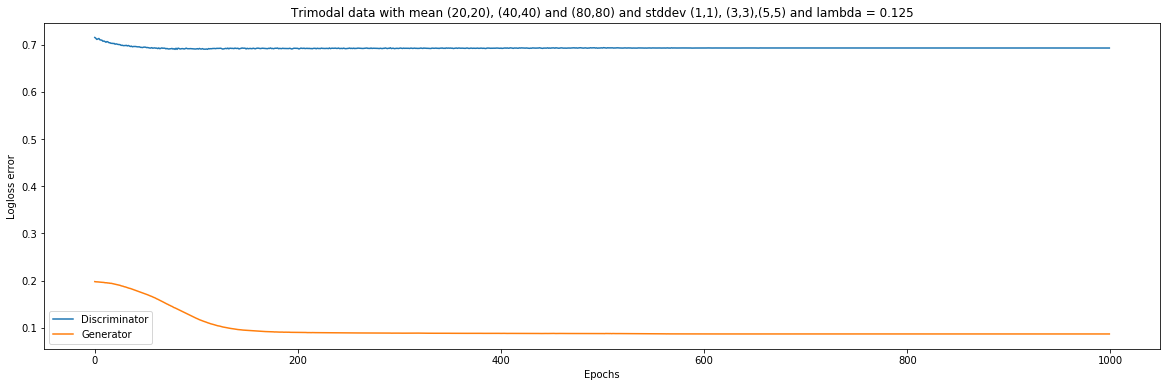

In [83]:
#graph comparison
fig,ax = plt.subplots(figsize = (20,6))
ax.plot(errorsd, label = "Discriminator")
ax.plot(errorsg, label = "Generator")
ax.set_xlabel('Epochs')
ax.set_ylabel('Logloss error')
ax.set_title('Trimodal data with mean (20,20), (40,40) and (80,80) and stddev (1,1), (3,3),(5,5) and lambda = 0.125')
ax.legend()
plt.show()

In [20]:
def comparedata(pp):
    pp = [list(np.array(x)) for x in pp]  
    pp = torch.tensor(pp)
    
#     print(pp.device)
    fig, ax = plt.subplots(1,3,figsize = (20,5))
    ax[0].scatter(pp[:,0],pp[:,1])
    ax[0].set_title('X-Y Plane')
    ax[1].scatter(pp[:,1],pp[:,2])
    ax[1].set_title('Y-Z Plane')
    ax[2].scatter(pp[:,0],pp[:,2])
    ax[2].set_title('X-Z Plane')
    
#     #gen data
    b = gen(pp[:,0:2].cuda()).cpu().detach()
#     print(b.device)
    fig2, ax2 = plt.subplots(1,3,figsize = (20,5))
    ax2[0].scatter(b[:,0],b[:,1],color = 'red')
    ax2[0].set_title('X-Y Plane')
    ax2[1].scatter(b[:,1],b[:,2],color = 'red')
    ax2[1].set_title('Y-Z Plane')
    ax2[2].scatter(b[:,0],b[:,2],color = 'red')
    ax2[2].set_title('X-Z Plane')
#     plt.title('Trimodal data with mean (1,1), (6,6) and (11,11) and stddev (0.5,0.5), (0.6,0.6),(1,1)')
    plt.show()

In [21]:
pp = []
for i in range(DATASET):
    pp.append(torch.load('data/'+ str(i+1) + '.pt'))

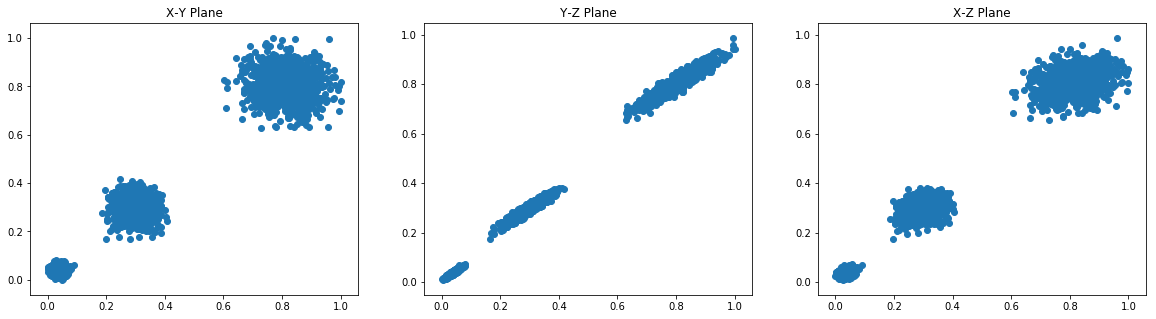

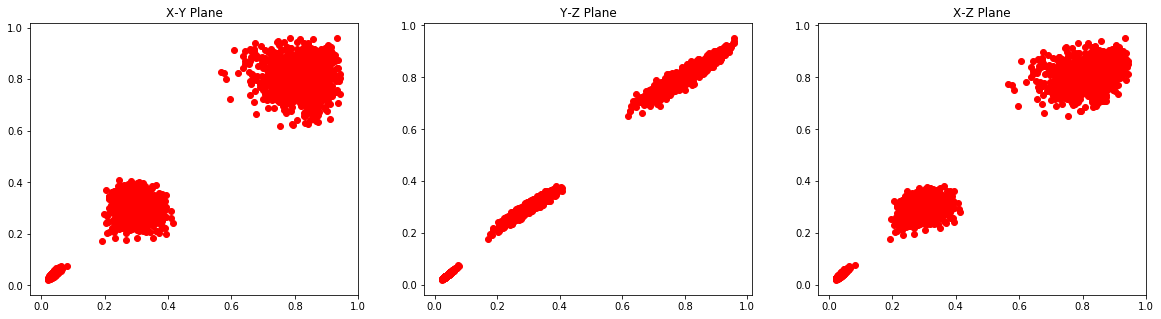

In [84]:
comparedata(pp)

# TESTING TIME!

In [27]:
TESTDATASET = 600

In [28]:
class TestPoints:
    def __init__(self,ids):
        self.ids = ids
    def __len__(self):
        return len(self.ids)
    def __getitem__(self,index):
        Id = self.ids[index]
        X = torch.load('testdata/'+str(Id)+'.pt')
        return X

In [29]:
ids = np.arange(1,TESTDATASET + 1,1)
testdata = TestPoints(ids)

In [30]:
test_loader = torch.utils.data.DataLoader(testdata, shuffle = False, batch_size=TESTDATASET,num_workers=0)

In [31]:
torch.set_printoptions(precision=10)

In [85]:
mseerror = 0.0
for testbatch in test_loader:
    testbatch = testbatch.cuda()
    actual_test = testbatch
    predicted_test = gen(testbatch[:,0:2])
    mseerror = loss_mse(predicted_test,actual_test)
print(mseerror.detach().cpu())

tensor(3.8920759835e-05)
